In [1]:
import os
from unstructured.partition.auto import partition
from unstructured.staging.base import elements_to_json
from unstructured_inference.models.base import get_model, get_default_model_mappings
from unstructured_inference.inference.layout import DocumentLayout
from bs4 import BeautifulSoup
import unicodedata
import re
from copy import deepcopy
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import patches

/data/hpc/potato/ecoit_summer/venv/pdf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd /data/hpc/potato/ecoit_summer
%env TESSERACT_CHARACTER_CONFIDENCE_THRESHOLD=-0.5

/data/hpc/potato/ecoit_summer
env: TESSERACT_CHARACTER_CONFIDENCE_THRESHOLD=-0.5


# Test API 

In [3]:
def clean_text(text):
    """
    Remove all hyperlinks from the input text, keeping only the visible text.
    Supports formats like <a href="...">text</a> and raw URLs.
    """
    # Remove HTML anchor tags but keep the text inside
    text = re.sub(r'<a [^>]*>(.*?)</a>', r'\1', text, flags=re.IGNORECASE)
    # Remove raw URLs (http, https, www)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = unicodedata.normalize("NFKD", text)
    return text.strip()

In [4]:
path = r"/data/hpc/potato/ecoit_summer/data/database/Báo cáo/Tieu chuan RMU 2017 5137.pdf"

In [5]:
get_default_model_mappings()

({'detectron2_onnx': unstructured_inference.models.detectron2onnx.UnstructuredDetectronONNXModel,
  'detectron2_quantized': unstructured_inference.models.detectron2onnx.UnstructuredDetectronONNXModel,
  'detectron2_mask_rcnn': unstructured_inference.models.detectron2onnx.UnstructuredDetectronONNXModel,
  'yolox': unstructured_inference.models.yolox.UnstructuredYoloXModel,
  'yolox_tiny': unstructured_inference.models.yolox.UnstructuredYoloXModel,
  'yolox_quantized': unstructured_inference.models.yolox.UnstructuredYoloXModel},
 {'detectron2_onnx': <unstructured_inference.utils.LazyDict at 0x7f9fae5c1c90>,
  'detectron2_quantized': {'model_path': '/work/hpc/cache/huggingface/hub/detectron2_quantized/detectrin2_quantized.onnx',
   'label_map': {0: 'Text', 1: 'Title', 2: 'List', 3: 'Table', 4: 'Figure'},
   'confidence_threshold': 0.8},
  'detectron2_mask_rcnn': <unstructured_inference.utils.LazyDict at 0x7f9fad695f90>,
  'yolox': <unstructured_inference.utils.LazyDict at 0x7f9fad6970d0>,

In [6]:
strategy = "hi_res" # Strategy for analyzing PDFs and extracting table structure
model_name = "detectron2_onnx" # Best model for table extraction. Other options are detectron2_onnx and cheaper depending on file layout

# Extracts the elements from the PDF
elements = partition(
        filename=path, 
        strategy=strategy,
        languages=["vie", "eng"],
        infer_table_structure=True,
        skip_infer_table_types = [],
        hi_res_model_name=model_name,
        )

# model = get_model("yolox")
# layout = DocumentLayout.from_file(path, detection_model=model, pdf_image_dpi=600)

AttributeError: 'list' object has no attribute 'element_coords'

In [ ]:
from unstructured_inference.inference.layoutelement import LayoutElements

NameError: name 'field' is not defined

In [ ]:
# example_page = layout.pages[1]
# image = example_page._get_image(path, 1, 600)
# elements = example_page.elements

In [ ]:
elements

[LayoutElement(bbox=Rectangle(x1=231.9386749267578, y1=129.48043823242188, x2=902.7511596679688, y2=177.6204071044922), text=None, source=<Source.YOLOX: 'yolox'>, type='Text', prob=0.6058272123336792, image_path=None, parent=None),
 LayoutElement(bbox=Rectangle(x1=214.17135620117188, y1=194.60479736328125, x2=588.6405029296875, y2=241.77508544921875), text=None, source=<Source.YOLOX: 'yolox'>, type='Section-header', prob=0.5511046051979065, image_path=None, parent=None),
 LayoutElement(bbox=Rectangle(x1=243.62063598632812, y1=260.50787353515625, x2=485.06646728515625, y2=297.6032409667969), text=None, source=<Source.YOLOX: 'yolox'>, type='Section-header', prob=0.47686946392059326, image_path=None, parent=None),
 LayoutElement(bbox=Rectangle(x1=241.14088439941406, y1=320.9368896484375, x2=1086.0384521484375, y2=360.6486511230469), text=None, source=<Source.YOLOX: 'yolox'>, type='Text', prob=0.6704851388931274, image_path=None, parent=None),
 LayoutElement(bbox=Rectangle(x1=246.384384155

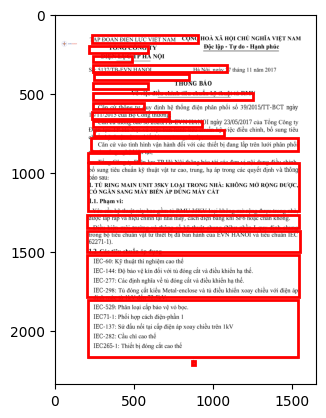

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(image)
for el in elements: 
    if el.bbox is not None:
        ax.add_patch(patches.Rectangle((el.bbox.x1, el.bbox.y1), el.bbox.x2 - el.bbox.x1, el.bbox.y2 - el.bbox.y1, fill=False, edgecolor='red', linewidth=2))
plt.show()

In [ ]:
elements_to_json(elements, r"logs/test_extract.json", encoding="utf-8")

NameError: name 'elements' is not defined

In [ ]:
tables = [el for el in elements if el.category == "Table"]

In [ ]:
for tab in tables: 
    html_table = tab.metadata.text_as_html
    table = BeautifulSoup(html_table, "html.parser")
    print(html_table)
    rows = table.find_all('tr')
    data = []
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) # Get rid of empty values
    print(data)

<table><thead><tr><th>Un|</th><th>In</th><th>L</th><th>D</th><th>lãi</th><th>13</th><th>Pn</th></tr></thead><tbody><tr><td></td><td>A</td><td>mm</td><td>mm</td><td>kA</td><td>A</td><td>W</td></tr><tr><td rowspan="8">KV}</td><td>10</td><td>442</td><td>50-70</td><td>| &gt;25</td><td>32-50</td><td>18-32</td></tr><tr><td>16</td><td>442</td><td>90-70</td><td>| &gt;25</td><td>42-65</td><td>31-59</td></tr><tr><td>25</td><td>442</td><td>90-70</td><td>| &gt;25</td><td>76- 105</td><td>60-80</td></tr><tr><td>3151</td><td>442</td><td>50-70</td><td>| &gt;25</td><td>98-135</td><td>80-97</td></tr><tr><td>40</td><td>442</td><td>90-70</td><td>| &gt;25</td><td>| 130-180</td><td>70-120</td></tr><tr><td>50</td><td>442</td><td>65-100</td><td>| &gt;25</td><td>175-265</td><td>75-135</td></tr><tr><td>80</td><td>442</td><td>65-100</td><td>| &gt;25</td><td>| 300-370</td><td>148-205</td></tr><tr><td>100</td><td>442</td><td>65-100</td><td>| &gt;25</td><td>| 420-550</td><td>220-250</td></tr></tbody></table>
[[], [

In [ ]:
def page_processor(elements):
    is_page_break = True
    data = []
    for el in elements:
        if len(el.text) <= 4:
            is_page_break = True
            print("break", el.text)
            continue

        if is_page_break and len(data) > 0:
            last = data[-1]
            print(el.category, el.text, last.text)
            if (el.category[-4:] == "Text" and el.text[0].islower()) and last.category not in ["PageBreak", "Footer", "Table", "Image", "FigureCaption"]:
                data[-1].text += " " + el.text.strip()
            elif (el.category == "Table" and last.category == "Table"):
                data[-1].metadata.text_as_html += el.metadata.text_as_html
                data[-1].text += " " + el.text.strip()
            else:
                data.append(el)
            # is_page_break = False
        else:
            data.append(el)
    return data

processed = page_processor(elements)
print(len(elements) - len(processed), "elements removed due to page breaks")

UncategorizedText ĐIỆN LỰC TP HÀ NỘI TẬP ĐOÀN ĐIỆN LỰC VIỆT NAM CỘNG HOÀ XÃ HỘI CHỦ NGHĨA VIỆT NAM TỔNG CÔNG TY Độc lập - Tự do - Hạnh phúc
NarrativeText Hà Nội, ngày 27 tháng 11 năm 2017 ĐIỆN LỰC TP HÀ NỘI
Title THÔNG BÁO Hà Nội, ngày 27 tháng 11 năm 2017
Title Về việc điều chỉnh tiêu chuẩn kỹ thuật tủ MU THÔNG BÁO
NarrativeText Căn cứ thông tư quy định hệ thống điện phân phối số 39/2015/TT-BCT ngày 18/11/2015 của Bộ Công thương; Về việc điều chỉnh tiêu chuẩn kỹ thuật tủ MU
NarrativeText Căn cứ thông o số 2325/TB-EVN HANOI ngày 23/05/2017 của Tổng Công ty Điện lực TP Hà Nội về việc an hành tiêu chuẩn kỹ việc điều chỉnh, ổ sung tiêu chuẩn kỹ thuật vật tư thiết ị cao, trung, hạ p; Căn cứ thông tư quy định hệ thống điện phân phối số 39/2015/TT-BCT ngày 18/11/2015 của Bộ Công thương;
NarrativeText Căn cứ vào tình hình vận hành đối với c c thiết ị đang lắp trên lưới phân phối và c c công nghệ hiện tại; Căn cứ thông o số 2325/TB-EVN HANOI ngày 23/05/2017 của Tổng Công ty Điện lực TP Hà Nội 

In [ ]:
types = dict()
for el in elements:
    if el.category not in types:
        types[el.category] = list()
    types[el.category].append(el)

for key, value in types.items():
    print(key + ":")
    print("\n".join([el.text for el in value]))

Title:
TẬP ĐOÀN ĐIỆN LỰC VIỆT NAM CỘNG HOÀ XÃ HỘI CHỦ NGHĨA VIỆT NAM TỔNG CÔNG TY Độc lập - Tự do - Hạnh phúc
THÔNG BÁO
Về việc điều chỉnh tiêu chuẩn kỹ thuật tủ MU
1. TỦ ING MAIN UNIT 35KV LOẠI T ONG NHÀ: KHÔNG MỞ ỘNG ĐƯỢC, CÓ NGĂN SANG MÁY BIẾN ÁP DÙNG MÁY CẮT
1.1. Phạm vi:
1.2. Các tiêu chuẩn áp dụng
1.3. Thông số kỹ thuật
1.3.1. Tủ RMU
1.4. Thiết kế chung
1.5. Thiết kế điện
1.6. Các thông tin cần cung cấp theo thiết :
1.7. Đặc tính kỹ thuật và cam kết: (Phụ lục 1)
2. TỦ ING MAIN UNIT 35KV LOẠI T ONG NHÀ: MỞ ỘNG ĐƯỢC CÓ NGĂN SANG MÁY BIẾN ÁP DÙNG MÁY CẮT
2.1. Phạm vi
2.2. Các tiêu chuẩn áp dụng
2.3.Thông số kỹ thuật
2.4.Thiết kế chung
2.5. Thiết kế điện
2.6. Các thông tin cần cung cấp theo thiết :
2.7. Đặc tính kỹ thuật và cam kết: (Phụ lục 2)
3. TỦ ING MAIN UNIT 35KV LOẠI NGOÀI T ỜI: KHÔNG MỞ ỘNG CÓ NGĂN SANG MÁY BIẾN ÁP DÙNG MÁY CẮT.
3.2. Các tiêu chuẩn áp dụng:
3.5. Thiết kế điện
3.6. Các thông tin cần cung cấp theo thiết :
3.7. Đặc tính kỹ thuật và cam kết: (Phụ lục 3)
4. TỦ ING

# Do some overall statistics

In [ ]:
# from copy import deepcopy
# import os
# data = []
# strategy = "hi_res"
# model_name = "yolox" 
# def crawl_dataset(path):
#     if os.path.isdir(path):
#         for file in os.listdir(path):
#             crawl_dataset(os.path.join(path, file))
#     else:
#         if not path.endswith(".ini") and not path.endswith(".doc"):
#             print("Processing file:", path)
#             elements = partition(
#                 filename=path, 
#                 strategy=strategy, 
#                 languages=["vie", "eng"],
#                 infer_table_structure=True,
#                 skip_infer_table_types = [],
#                 hi_res_model_name=model_name
#             )
#             data.extend(deepcopy(elements))

# crawl_dataset("data/TCKT upload")

In [ ]:
# types = dict()
# for el in data:
#     if el.category not in types:
#         types[el.category] = list()
#     types[el.category].append(el)

# for key, value in types.items():
#     print(key + ":")
#     print("\n".join([el.text for el in value]))

In [ ]:
# for key, value in types.items():
#     print(f"{key}: {len(value)} elements")

The category shit only works on well-composed documents, else are trashed

# Testing manual filtering and formatting

In [ ]:
hierarchy_regex = {r"(?i)\b(?:chương|phụ\s*lục|phần)\s+(?:\d+|[ivx]+)(?:\.(?:\d+|[ivx]+))*[:\.]?": 1,
                   r"\bmục\s+(?:\d+|[ivx]+)(?:\.(?:\d+|[ivx]+))*[:\.]?": 2,
                   r"\b(?:điều|khoản)\s+\d+(?:\.(?:\d+|[ivx]+))*[:\.]?": 3,
                   r'^([ivx]+)(?:\.(?:\d+|[ivx]+))*\.+[\t\s]': 4,
                   r"^(\d+)(?:\.(?:\d+))*\.+[\t\s]": 5,
                   r'^[a-z]+[\.\)/]+[\t\s]': 6,
                   r"^[-]+[\t\s]": 7,
                   r"^[+]+[\t\s]": 8}
roman_pattern = re.compile(r"""
    (XC|XL|L?X{0,3})     # Tens - 90 (XC), 40 (XL), 0-30 (0 to 3 X's), or 50-80 (L plus 0 to 3 X's)
    (IX|IV|V?I{0,3})     # Ones - 9 (IX), 4 (IV), 0-3 (I's), or 5-8 (V plus 0 to 3 I's)
    $""", re.VERBOSE)

In [ ]:
re.match(r"\bmục\s+(?:\d+|[ivxl]+)(?:\.(?:\d+|[ivx]+))*^[:\.]?", "mục lục")
#ivdx

In [ ]:
def parse_content(title, content):
    return [f"({t}) {c}" for t, c in zip(title, content) if len(c) > 0]

def roman_to_int(roman):
    roman_values = {
        'I': 1, 'V': 5, 'X': 10
    }

    total = 0
    prev_value = 0

    for char in reversed(roman.upper()):
        value = roman_values.get(char, 0)
        if value < prev_value:
            total -= value
        else:
            total += value
            prev_value = value

    return total

def character_to_int(str):
    return sum([(ord(char) - ord('a') + 1) * (1 + (len(str) - index - 1) * 26) for index, char in enumerate(str.lower())])

def numel_to_int(str):
    return int(str)

def to_int(str):
    
    # print(f"Converting: ({str})")
    if roman_pattern.match(str.upper()):
        return roman_to_int(str)
    elif re.match(r"^\d+", str):
        return numel_to_int(str)
    elif re.match(r"^[a-z]", str):
        return character_to_int(str)
    else:
        return [-1] # Negative value indicates an invalid input

def numbering(text):
    """
    Convert a string to an integer based on its numbering system.
    Supports Roman numerals, Arabic numerals, and lowercase letters.
    """
    return [to_int(part) for part in re.split(r"[:.\s]+", text) if part.strip() != '']


In [ ]:
def table_depth(element):
    return (-10, 0)

In [ ]:
def text_depth(element):
    """
    Calculate the depth of the text content based on its structure.
    """
    content = element.text.strip().strip("\"").lower()
    if not content:
        return (11, [-1])
    for pattern, order in hierarchy_regex.items():
        matched = re.match(pattern, content)
        if matched:
            if order <= 6:
                return (order, numbering(matched.group().replace("  " , " ").split()[-1]))
            else:
                return (order, [0])
    return (10, [0])  # Default case if no pattern matches

In [ ]:
def element_depth(element):
    if element.category in ['Image', 'FigureCaption', 'Page', 'PageBreak', 'Footer']:
        return 11
    elif element.category.endswith("Text"):
        return text_depth(element)
    elif element.category == "Table":
        return table_depth(element)
    else:
        return text_depth(element)

In [ ]:
for el in elements:
    if el.category[-4:] != "Table":
        el.metadata.text = clean_text(el.text)
        el.metadata.depth = text_depth(el)
    print(element_depth(el), el.category, el.metadata.category_depth, el.text)
    

(10, [0]) Title None TẬP ĐOÀN ĐIỆN LỰC VIỆT NAM CỘNG HOÀ XÃ HỘI CHỦ NGHĨA VIỆT NAM TỔNG CÔNG TY Độc lập - Tự do - Hạnh phúc
(10, [0]) UncategorizedText None ĐIỆN LỰC TP HÀ NỘI
(10, [0]) NarrativeText None Hà Nội, ngày 27 tháng 11 năm 2017
(10, [0]) Title None THÔNG BÁO
(10, [0]) Title None Về việc điều chỉnh tiêu chuẩn kỹ thuật tủ MU
(10, [0]) NarrativeText None Căn cứ thông tư quy định hệ thống điện phân phối số 39/2015/TT-BCT ngày 18/11/2015 của Bộ Công thương;
(10, [0]) NarrativeText None Căn cứ thông o số 2325/TB-EVN HANOI ngày 23/05/2017 của Tổng Công ty Điện lực TP Hà Nội về việc an hành tiêu chuẩn kỹ việc điều chỉnh, ổ sung tiêu chuẩn kỹ thuật vật tư thiết ị cao, trung, hạ p;
(10, [0]) NarrativeText None Căn cứ vào tình hình vận hành đối với c c thiết ị đang lắp trên lưới phân phối và c c công nghệ hiện tại;
(10, [0]) NarrativeText None Tổng Công ty Điện lực TP Hà Nội thông o tới c c đơn vị nội dung điều chỉnh, ổ sung tiêu chuẩn kỹ thuật vật tư cao, trung, hạ p trong c c quyết đ

In [ ]:
class DocumentNode:
    def __init__(self, depth, path = "", element = None, father = None, prefix = ""):
        self.depth = depth
        self.father = father
        self.children = defaultdict(list)
        self.element = element
        self.prefix = prefix
        self.content = clean_text(element.text) if element else ""
        self.path = element.metadata.filename if element else path
    
    def set_father(self, father):
        if not self.check_father(father):
            return False
        depth, lev = self.depth
        # Get last elements since father is indicated beforehand
        lev = lev[-1] if isinstance(lev, list) else lev
        self.father = father
        father.children[depth].append(self)
        if lev == 0:
            lev = len(self.father.children[depth])
            self.depth = (depth, [lev])
        self.path = father.path + "/" + f"{self.prefix}{depth}.{lev}"
        return True

    def check_father(self, node):
        """
        Check if the element is a child of this node.
        """
        n_depth, n_lev = node.depth
        s_depth, s_lev = self.depth
        if n_depth > s_depth or n_depth < 0:
            return False
        elif (n_depth == s_depth) and (len(s_lev) - len(n_lev) == 1):
            for s_l, n_l in zip(s_lev[:-1], n_lev):
                if s_l != n_l:
                    return False
            if s_depth not in node.children.keys() and s_lev[-1] > 1:
                return False
            # Add tolerance for falsely partitioning
            elif s_lev[-1] > len(node.children[s_depth]) + 2: 
                return False
            return True
        elif (n_depth < s_depth):
            if s_depth not in node.children.keys() and s_lev[-1] > 1:
                return False
            # Add tolerance for falsely partitioning
            elif s_lev[-1] > len(node.children[s_depth]) + 2: 
                return False
            return True
        else: 
            return False
            
    def __repr__(self):
        return f"DocumentNode(depth={self.depth}, path={self.path}, content={self.content[:30]})"
    
            

In [ ]:
root = DocumentNode(depth=(0, [0]), path="")

In [ ]:
document_stack = [root]
tabled = True
for el in processed:
    if el.category[-4:] != "Table":
        depth = text_depth(el)
        if depth[0] == 11:
            continue
        elif depth[0] == 10 and el.category == "ListItem":
            depth = (6, [0])
        el_node = DocumentNode(depth, element=el, father=None)
        for node in document_stack[::-1]:
            if el_node.set_father(node):
                break
        document_stack.append(el_node)

In [ ]:
for node in document_stack:
    print(node.depth, node.path, node.element.text if node.element else "")

(0, [0])  
(10, [1]) /10.1 TẬP ĐOÀN ĐIỆN LỰC VIỆT NAM CỘNG HOÀ XÃ HỘI CHỦ NGHĨA VIỆT NAM TỔNG CÔNG TY Độc lập - Tự do - Hạnh phúc
(10, [2]) /10.2 ĐIỆN LỰC TP HÀ NỘI
(10, [3]) /10.3 Hà Nội, ngày 27 tháng 11 năm 2017
(10, [4]) /10.4 THÔNG BÁO
(10, [5]) /10.5 Về việc điều chỉnh tiêu chuẩn kỹ thuật tủ MU
(10, [6]) /10.6 Căn cứ thông tư quy định hệ thống điện phân phối số 39/2015/TT-BCT ngày 18/11/2015 của Bộ Công thương;
(10, [7]) /10.7 Căn cứ thông o số 2325/TB-EVN HANOI ngày 23/05/2017 của Tổng Công ty Điện lực TP Hà Nội về việc an hành tiêu chuẩn kỹ việc điều chỉnh, ổ sung tiêu chuẩn kỹ thuật vật tư thiết ị cao, trung, hạ p;
(10, [8]) /10.8 Căn cứ vào tình hình vận hành đối với c c thiết ị đang lắp trên lưới phân phối và c c công nghệ hiện tại;
(10, [9]) /10.9 Tổng Công ty Điện lực TP Hà Nội thông o tới c c đơn vị nội dung điều chỉnh, ổ sung tiêu chuẩn kỹ thuật vật tư cao, trung, hạ p trong c c quyết định và thông báo sau:
(5, [1]) /5.1 1. TỦ ING MAIN UNIT 35KV LOẠI T ONG NHÀ: KHÔNG MỞ 